# On delayed conversions in real-world online marketing


  * This code includes all needed material to reproduce the real data experiments of submission 7109
  * For details about the content of the Dataset, refer to https://ailab.criteo.com/criteo-attribution-modeling-bidding-dataset/ 
  and 
  
  “Attribution Modeling Increases Efficiency of Bidding in Display Advertising”
Eustache Diemert*, Julien Meynet* (Criteo AI Lab), Damien Lefortier (Facebook), Pierre Galland (Criteo) *authors contributed equally

# Preprocessing

In [1]:
%pylab inline
import pandas as pd
plt.style.use('ggplot')
from scipy.optimize import minimize

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
DATA_FILE='~/Documents/data/criteo_attribution_dataset.tsv.gz' #your local directory
df = pd.read_csv(DATA_FILE, sep='\t', compression='gzip')

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Dragos/Documents/data/criteo_attribution_dataset.tsv.gz'

In [ ]:
df['gap_click_sale'] = -1
df.loc[df.conversion == 1, 'gap_click_sale'] = df.conversion_timestamp - df.timestamp

In [ ]:
FEATURES = ['campaign', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 
            'cat7', 'cat8']
INFOS = ['cost', 'cpo', 'time_since_last_click']

# Model Sanity check : correlation of action features and delays

In this section we empirically validate the assumption that delays are independent of the actions. Conditionally on a conversion having happened (i.e. delay is observed), we compute the correlation coefficient of the delays with respect to the features of the contextual action taken. 
For that purpose, we use the hashing trick (https://en.wikipedia.org/wiki/Feature_hashing) to transform the vector of categorical variables contained in FEATURES that include both the campaign and the categorical variables describing the session. 

In [ ]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.feature_extraction import FeatureHasher
from sklearn.metrics import log_loss

def to_dict_values(sub_df, features):
    return [dict([(_[0]+str(_[1]),1) for _ in zip(features,l)]) for l in sub_df.values]

features = FEATURES
  
# extract sub data frames containing the features
df_converted = df[df.conversion == 1]
#we want to regress delays :
y = df_converted['gap_click_sale']
# using the available features:
X = df_converted[features]
#hashing trick
hasher = FeatureHasher(n_features=2*9, non_negative=1)

X_h = hasher.fit_transform(to_dict_values(X,features))

reg = LinearRegression().fit(X_h,y)




In [ ]:
reg.score(X_h,y)

## conclusion:
The correlation coefficient is $r=0.0217$ so delays are not correlated with the action features. The hypothesis that delays are independent on the action taken, conditionally on this action being converted, is valid. 

# Delay distribution

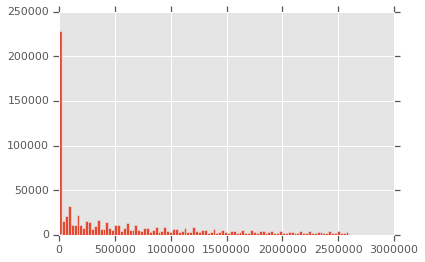

In [ ]:
# @title First check, plot the histogram of delays (when observed, that is conditionally on conversions)
histo = df.gap_click_sale[df.conversion == 1].hist(bins = 100)

(577.0, 19473174.819347348)


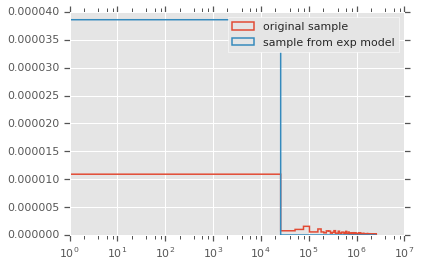

In [ ]:
# @title Fit an exponential law : Not convincing !
# tails are heavier

from math import log
import scipy.stats as ss

#histogram from real data (normalized)
D = np.array(y).astype(float)
cnts, bins, p = plt.hist(D, label='original sample', bins=100, histtype='step', linewidth=1.5, normed = True)

#MLE
rv = ss.expon()
exp_model = ss.expon.fit(X)
print exp_model

y_exp_model = rv.pdf( bins)
sample_exp_model = rv.rvs(size=1000)

# Histogram of datapoints sampled from KDE
plt.hist(sample_exp_model, label='sample from exp model', bins=bins,histtype='step', linewidth=1.5, normed = True)

# Visualize the kde itself
#plt.plot(bins, y_exp_model, label='exp model')
plt.legend()
plt.xscale('log')
plt.show()

## Doesn't seem to work at all

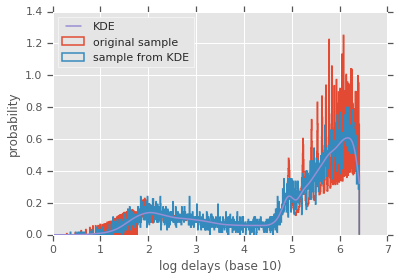

In [ ]:
# @title Second attempt : fitting a KDE on logarithmic delays
# ''' Seems much more convincing'''


#histogram from real data (normalized)
D = np.array(y).astype(float)
D = np.log10(D)

# Generate a KDE from the empirical sample
sample_pdf = ss.gaussian_kde(D)

# Sample new datapoints from the KDE
new_sample_data = sample_pdf.resample(10000).T[:,0]

# Histogram of initial empirical sample
cnts, bins, p = plt.hist(D, label='original sample', bins=1000, histtype='step', linewidth=1.5, normed=True)

# Histogram of datapoints sampled from KDE
plt.hist(new_sample_data, label='sample from KDE', bins=bins,histtype='step', linewidth=1.5, normed = True)

# Visualize the kde itself
y_kde = sample_pdf(bins)
plt.plot(bins, y_kde, label='KDE')
plt.legend(loc=2)
plt.xlabel("log delays (base 10)")
plt.ylabel("probability")
plt.show()

In [ ]:
np.savetxt('./figures/emp_dist_delay',y_kde) ## your local directory
np.savetxt('./figures/emp_dist_delay_log_values',bins) ## your local directory
np.sum(y_kde)

152.05381588949945

## Delayed Linear Bandits
We test linear regression and logistic regression on the data. Due to very low conversion probability, linear regression is not the right model but logistic regression shows satisfying R2 scores. 

In [ ]:
# just splitting the dataset into days and hours

df['day'] = np.floor(df.timestamp / 86400.).astype(int)
df['hour'] = np.floor(df.timestamp / 3600).astype(int)

In [ ]:
# fit Linear regression FEATURES -> conversion
#we want to regress delays :

# using the available features:
sub_df_train = df[df.hour <= 10]#.sample(n=100000)
X_train = sub_df_train[features]
y_train = sub_df_train['conversion']

sub_df_test = df[df.hour == 11 ]#.sample(n=1000)
X_test = sub_df_test[features]
y_test = sub_df_test['conversion']

#hashing trick
hasher = FeatureHasher(n_features=2**7, non_negative=1)

X_train_h = hasher.fit_transform(to_dict_values(X_train,features))
X_test_h = hasher.transform(to_dict_values(X_test,features))

lin_reg = LinearRegression().fit(X_train_h,y_train)

print 'score', lin_reg.score(X_test_h,y_test)

In [ ]:
lin_reg.coef_

In [ ]:
# let's also try LogisticRegression

# using the available features:
sub_df_train = df.sample(n=100000)
X_train = sub_df_train[features]
y_train = sub_df_train['conversion']

sub_df_test = df.sample(n=1000)
X_test = sub_df_test[features]
y_test = sub_df_test['conversion']

#hashing trick
hasher = FeatureHasher(n_features=2**7, non_negative=1)

X_train_h = hasher.fit_transform(to_dict_values(X_train,features))
X_test_h = hasher.transform(to_dict_values(X_test,features))

log_reg = LogisticRegression().fit(X_train_h,y_train)

print 'score', log_reg.score(X_test_h,y_test)

## Checking non-stationarity
It is worth checking how stationary is the model (additional tests)

In [ ]:
#   import pdb; pdb.set_trace()
from numpy.linalg import norm

    
thetas = pd.DataFrame()
delta_thetas = pd.DataFrame()

hour_range = range(24)

for h in hour_range:
  
  # using the available features:
  sub_df_train = df[df.hour == h]
  X_train = sub_df_train[features]
  y_train = sub_df_train['conversion']

  sub_df_test = df[df.hour == h+1].sample(n=1000)
  X_test = sub_df_test[features]
  y_test = sub_df_test['conversion']

  #hashing trick
  hasher = FeatureHasher(n_features=2**7, non_negative=1)

  X_train_h = hasher.fit_transform(to_dict_values(X_train,features))
  X_test_h = hasher.transform(to_dict_values(X_test,features))

  log_reg = LogisticRegression().fit(X_train_h,y_train)
  #thetas.append([log_reg.coef_, log_reg.score(X_test_h,y_test)], ignore_index = True)
  normalized_coef = log_reg.coef_/norm(log_reg.coef_[0])
  temp = pd.DataFrame(normalized_coef)
  #score = log_reg.score(X_test_h,y_test)
  thetas = thetas.append(temp, ignore_index=True)
  #thetas[thetas.loc[h],'score'] = score
  
  delta_theta = normalized_coef- np.array(thetas.loc[max(h-1, 0)])
  delta_theta.shape = (1,128)
  dtemp = pd.DataFrame(delta_theta)
  delta_thetas = delta_thetas.append(dtemp, ignore_index = True)
  #import pdb; pdb.set_trace()

 


In [ ]:
thetas.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
0,-0.000984,0.078232,-0.007548,-0.019870,-0.066302,-0.101662,-0.107169,0.043184,-0.131795,0.087657,-0.068070,-0.052115,-0.165221,0.064982,-0.002294,-0.023042,0.077504,-0.029111,0.060043,-0.034939,-0.026279,0.004823,0.025028,-0.044614,-0.084155,0.030068,-0.029267,0.116587,-0.253219,0.086864,0.166478,0.017501,0.046867,-0.038909,-0.076439,0.018439,0.046963,0.020992,0.018260,-0.025397,...,-0.083931,0.056393,-0.008993,-0.044156,-0.053825,-0.118008,-0.000150,0.069254,0.046545,0.055114,-0.080108,-0.276808,-0.037686,0.022917,0.056876,0.022180,-0.001428,-0.035762,0.020758,-0.071494,-0.079161,0.032379,0.027552,0.118024,0.003747,-0.209944,-0.071557,0.057815,-0.107900,-0.056470,-0.081207,0.079388,-0.097133,-0.065959,0.142255,0.064439,0.052156,0.021910,0.116720,0.025609
1,-0.060965,-0.040530,0.059723,-0.071086,0.086589,-0.128625,-0.110499,-0.123728,-0.099702,-0.050421,-0.095577,0.052406,-0.073066,0.112586,-0.011844,-0.000049,0.251106,-0.186984,-0.101653,-0.088338,0.084353,0.091037,0.061712,-0.021857,-0.113150,0.017010,0.004660,0.101713,-0.195267,0.049594,0.112147,-0.018996,-0.065296,0.082136,-0.157064,-0.056308,-0.057772,0.075193,-0.215200,-0.130712,...,-0.040143,0.054924,-0.010777,0.019169,0.029471,-0.001891,0.104064,0.047765,-0.009942,0.127683,-0.113397,-0.161715,-0.026254,0.042735,-0.026701,-0.116504,-0.181596,-0.028041,0.012613,-0.104848,-0.045796,0.005348,-0.118888,0.070879,-0.018073,-0.129474,0.007912,-0.158987,-0.001011,-0.010519,-0.046160,-0.014934,-0.030941,-0.069823,0.074915,-0.028882,0.101880,-0.015731,0.004969,-0.129915
2,-0.020291,-0.054943,0.069798,-0.039090,0.052130,0.138680,-0.026991,-0.122387,-0.019564,0.013524,-0.110423,-0.156906,-0.051305,0.122870,-0.051320,0.079988,-0.002030,0.018123,-0.011310,-0.144023,-0.081122,0.101133,0.020063,0.065142,0.054720,-0.061951,-0.085674,-0.076245,-0.113955,-0.085944,0.050899,-0.026055,0.131375,0.164736,0.069853,0.015793,0.220057,0.020210,0.028250,0.022671,...,-0.071550,-0.076221,-0.125320,0.067572,0.001379,0.048254,0.230720,-0.169237,0.032426,0.027527,0.052708,-0.098895,0.005574,0.003859,-0.038088,-0.080487,-0.085547,-0.106718,-0.086081,0.009750,-0.068567,0.025014,0.038123,0.132310,0.131949,-0.212881,0.121066,-0.008842,-0.043736,-0.011318,-0.140830,0.045143,0.017210,-0.070265,-0.119778,0.158936,0.065066,-0.142267,-0.097072,-0.028193
3,0.024083,0.013877,0.061858,-0.110405,0.045890,-0.077776,-0.231529,-0.094919,-0.022260,-0.038864,0.003111,-0.127940,0.017877,0.062316,-0.038351,-0.000630,-0.026421,-0.016076,-0.030463,-0.027513,-0.000306,0.110219,0.030540,-0.144352,-0.140552,-0.006668,0.155823,-0.089607,-0.095642,-0.088141,0.070008,-0.060316,-0.043580,0.039003,-0.086114,-0.072440,0.124244,-0.056213,-0.001377,0.019695,...,-0.062442,0.059102,-0.022879,-0.032642,-0.100726,-0.002486,-0.009246,-0.000780,-0.171614,0.099696,-0.049756,-0.161103,-0.006578,0.046534,-0.200686,0.070483,0.068711,0.019573,-0.053952,0.060949,-0.135623,0.158582,0.052962,-0.048163,0.030516,-0.216648,-0.063514,-0.036284,-0.074664,-0.164321,0.047917,-0.001313,0.031601,-0.013504,-0.166076,-0.011717,-0.018706,0.028620,-0.042089,0.058019
4,-0.090273,-0.048161,0.063800,-0.124245,-0.068501,-0.074391,0.002395,-0.077521,-0.038794,0.019774,-0.015129,-0.016301,-0.208287,0.022110,-0.090606,-0.043156,0.145630,0.018476,-0.098366,-0.092749,-0.065011,-0.013263,0.080996,0.141219,0.048891,0.099975,0.039436,0.080319,0.010659,0.083371,-0.025561,0.032586,-0.010643,-0.278357,0.025410,0.041232,0.025571,-0.028149,-0.229251,0.035862,...,-0.110244,0.002689,-0.139610,0.015123,0.025836,0.021734,0.064332,-0.014785,-0.097402,0.090252,0.019840,-0.236294,0.053359,0.022931,0.003990,-0.154942,-0.060500,-0.004596,-0.044837,0.027400,-0.026622,-0.105898,0.017066,-0.090236,-0.028185,-0.207390,-0.065470,-0

In [ ]:
delta_thetas.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.059981,-0.118762,0.067271,-0.051216,0.152891,-0.026963,-0.003330,-0.166912,0.032093,-0.138078,-0.027507,0.104521,0.092155,0.047604,-0.009550,0.022994,0.173602,-0.157873,-0.161697,-0.053399,0.110632,0.086214,0.036685,0.022756,-0.028995,-0.013058,0.033928,-0.014874,0.057951,-0.037270,-0.054331,-0.036497,-0.112163,0.121045,-0.080624,-0.074747,-0.104735,0.054201,-0.233460,-0.105315,...,0.043788,-0.001469,-0.001785,0.063325,0.083296,0.116117,0.104214,-0.021490,-0.056487,0.072569,-0.033289,0.115093,0.011432,0.019819,-0.083578,-0.138685,-0.180169,0.007721,-0.008146,-0.033353,0.033365,-0.027031,-0.146441,-0.047145,-0.021820,0.080471,0.079469,-0.216802,0.106889,0.045951,0.035047,-0.094322,0.066193,-0.003864,-0.067341,-0.093321,0.049724,-0.037641,-0.111752,-0.155524
2,0.040674,-0.014413,0.010075,0.031996,-0.034460,0.267306,0.083508,0.001342,0.080138,0.063945,-0.014846,-0.209312,0.021762,0.010284,-0.039475,0.080036,-0.253136,0.205107,0.090343,-0.055685,-0.165475,0.010096,-0.041649,0.086999,0.167869,-0.078961,-0.090335,-0.177958,0.081312,-0.135537,-0.061248,-0.007060,0.196670,0.082600,0.226916,0.072101,0.277829,-0.054983,0.243451,0.153383,...,-0.031406,-0.131146,-0.114543,0.048403,-0.028092,0.050145,0.126656,-0.217002,0.042368,-0.100157,0.166105,0.062821,0.031829,-0.038876,-0.011387,0.036017,0.096050,-0.078678,-0.098694,0.114597,-0.022772,0.019666,0.157012,0.061431,0.150022,-0.083408,0.113153,0.150145,-0.042725,-0.000800,-0.094670,0.060076,0.048150,-0.000442,-0.194692,0.187818,-0.036815,-0.126537,-0.102041,0.101722
3,0.044374,0.068820,-0.007940,-0.071315,-0.006239,-0.216456,-0.204537,0.027467,-0.002696,-0.052388,0.113534,0.028966,0.069181,-0.060554,0.012969,-0.080617,-0.024391,-0.034199,-0.019153,0.116509,0.080815,0.009086,0.010477,-0.209494,-0.195272,0.055283,0.241497,-0.013362,0.018314,-0.002197,0.019109,-0.034260,-0.174955,-0.125733,-0.155967,-0.088232,-0.095813,-0.076424,-0.029627,-0.002976,...,0.009107,0.135323,0.102441,-0.100214,-0.102105,-0.050740,-0.239966,0.168457,-0.204039,0.072170,-0.102464,-0.062208,-0.012152,0.042675,-0.162597,0.150971,0.154258,0.126291,0.032129,0.051200,-0.067056,0.133568,0.014839,-0.180474,-0.101433,-0.003767,-0.184580,-0.027442,-0.030928,-0.153003,0.188748,-0.046456,0.014391,0.056760,-0.046298,-0.170653,-0.083772,0.170887,0.054983,0.086213
4,-0.114356,-0.062038,0.001942,-0.013840,-0.114391,0.003385,0.233924,0.017398,-0.016534,0.058638,-0.018240,0.111638,-0.226163,-0.040205,-0.052255,-0.042527,0.172051,0.034552,-0.067903,-0.065236,-0.064705,-0.123482,0.050457,0.285570,0.189443,0.106643,-0.116387,0.169926,0.106300,0.171512,-0.095568,0.092902,0.032937,-0.317360,0.111525,0.113672,-0.098673,0.028064,-0.227874,0.016167,...,-0.047802,-0.056413,-0.116731,0.047765,0.126562,0.024220,0.073579,-0.014005,0.074212,-0.009445,0.069596,-0.075191,0.059937,-0.023603,0.204675,-0.225425,-0.129210,-0.024169,0.009115,-0.033549,0.109001,-0.264480,-0.035896,-0.042072,-0.058701,0.009259,-0.001956,0.020483,-0.047586,0.133175,-0.000433,0.079803,-0.029433,0.22

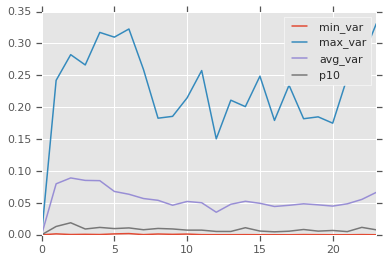

In [ ]:
delta_thetas = delta_thetas.applymap(lambda x: abs(x))
delta_thetas['min_var'] = delta_thetas.apply(np.min, axis = 1)
delta_thetas.min_var.plot()
delta_thetas['max_var'] = delta_thetas.apply(np.max, axis = 1)
delta_thetas.max_var.plot()
delta_thetas['avg_var'] = delta_thetas.apply(np.mean, axis = 1)
delta_thetas.avg_var.plot()
delta_thetas['p10'] = delta_thetas.apply(lambda x: np.percentile(x,q=10), axis = 1)
delta_thetas.p10.plot()
plt.legend()